In [3105]:
# %run ./new_matrix_EDA.ipynb

In [3420]:
df = pd.DataFrame(result_array,columns = ["_id","bias","prec","temp","delay"])

In [3457]:
ruggles = df[df["_id"] == "O70012_0"]
ruggles

,_id,bias,prec,temp,delay
35,O70012_0,1.0,0.0,37.2,62.0
36,O70012_0,1.0,0.004,36.6,62.0
37,O70012_0,1.0,0.004,37.2,-11.0
38,O70012_0,1.0,0.0,37.2,62.0
39,O70012_0,1.0,0.0,38.0,25.0
40,O70012_0,1.0,0.0,36.7,25.0
41,O70012_0,1.0,0.0,37.0,25.0


In [3113]:
# df.to_csv("mbta_weather.csv",index=False)

# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data

In [2842]:
"""
x: weather data (3xN) (april 1st until now)
[[percip1, percip2, percip3, percip4],
 [temp1,   temp2,   ...]
 [bias1,   bias2,   ...]]

y: mbta delays  (1xN) (april 1st until now)
[[delay1,  delay2,  ...]]
includes non-delays.
""";

In [3262]:
# x_noid = x_noid.astype(float)

In [3264]:
# y_noid = y_noid.astype(float)

In [3266]:
# x_noid.shape

In [3284]:
spt = pd.read_csv(r"C:\Users\Overl\DS4420\assets\HW4\ds4420_spotify.csv")

In [3290]:
spt = spt[["release_month","release_year","artist_pop","track_pop","duration_s","explicit"]]

In [3302]:
x = spt[["release_month","release_year","artist_pop","duration_s","explicit"]].to_numpy()

In [3304]:
y = spt["track_pop"].to_numpy()

# pointers
(set pointers for x_train, x_test, y_train, y_test)

In [3164]:
# overwrite when ready.....
x_train = x_noid[:-200]
x_test  = x_noid[-200:]
y_train = y_noid[:-200]
y_test  = y_noid[-200:]

In [8]:
# x = np.ones((3,10))
# y = np.ones((1,10))

In [9]:
x = np.array([
     1, 2, 3, 4, 5, 6, 7, 8, 9, 0,
    12, 1,-3,22, 3,-1, 2,31,31, 0,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
]).reshape(3,-1)
x

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0],
       [12,  1, -3, 22,  3, -1,  2, 31, 31,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [10]:
y = 2*x[0,:] + np.random.normal(0,0.25,10).reshape(1,-1)
y

array([[ 1.73479592,  3.80050051,  6.01862263,  7.87977243,  9.68051088,
        11.75259277, 13.68534001, 15.83761103, 17.70600538, -0.29470625]])

# define MLP

In [2882]:
class AbstractAF:
    """Abstract Activation Function.
    This is an abstract class used to represent
    activation functions in a MultiLayer Perceptitron.

    Each Activation function must have a name
    and implement the following three functions:
    - fw(w,x)         represents a forward pass through the MLP
    - bp_w(w,x)       represents a dL/dw backprop through the MLP
    - bp_x(w,x)       represents a dL/dh backprop through the MLP <- TODO look into this.....

    This class does not implement any of the three functions.
    Child-classes MUST implement all three functions for 
    backprop to work properly.

    In the current implementation, the following classes are the only valid subclasses:
    - LinearAF
    - ReluAF
    """
    def __init__(self):
        self.name = "Abstract"

    def __repr__(self):
        """Overwrites the representation with class name.
        This function makes the print look cleaner :) 
        """
        return f"<ActivationFunction:{self.name}>"
    
    def fw(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

    def bp_w(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

    def bp_x(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

class MeanSquaredErrorAF(AbstractAF):
    """Mean Squared Error function"""
    def __init__(self):
        super().__init__()
        self.name = "MSE"
        self.axis = 0

    def fw(self,f,y):
        return   np.mean((f-y)**2,axis=1).item()

    def bp(self,f,y):
        return 2*np.mean((f-y),   axis=self.axis)

class LinearAF(AbstractAF):
    """Linear Activation Function"""
    def __init__(self):
        super().__init__()
        self.name = "Linear"
    
    def fw(self,w,x):
        return w.T.dot(x)

    def bp_w(self,w,x):
        return x

    def bp_x(self,w,x):
        return w

class ReluAF(AbstractAF):
    """Relu Activation Function"""
    def __init__(self):
        super().__init__()
        self.name = "Relu"
        
    def fw(self,w,x):
        return np.maximum(0,w.T.dot(x))

    def bp_w(self,w,x):
        print("wtx:",(w.T.dot(x) > 0).shape)
        print("x:",x.shape,"(expected)")
        return x.dot((w.T.dot(x) > 0).T)

    def bp_x(self,w,x):
        print("wtx:",(w.T.dot(x) > 0).shape)
        print("w:",w.shape,"(expected)")
        return (w).dot(w.T.dot(x) > 0)

In [2899]:
class MLP:
    """MultiLayer Perceptron
    Implementation Notes:
    - input and output layers must be defined explicitly.
    """
    def __init__(self):
        self.layers  = []
        self.weights = []
        self.loss = MeanSquaredErrorAF()

    def add_layer(self,nodes:int,afunc:AbstractAF) -> None:
        """Adds a layer with a given number of nodes
        and a given Abstract Function"""
        self.layers.append(MLPLayer(nodes,afunc))

    def _init_weights(self) -> None:
        """Initialize weights based on added layers"""
        assert len(self.layers) > 1, "layers must be added"

        # reset weights matrix
        self.weights = []

        # get the shape based on existing layers
        for i in range(1,len(self.layers)):
            w_shape = (self.layers[i-1].get_nodes(),
                       self.layers[i  ].get_nodes())
            self.weights.append(np.ones(w_shape)*0.01)

    def fw(self,x:np.array):
        """Performs a forward pass from
        x through n hidden layers to f_w(x)
        by applying an activation function 
        for each layer in the MLP.

        The function also initializes weight
        dimensions, if not done so already.

        Given the input example:
        x_ample = np.ones((3,n))
        
        each column would represent a sample
        ie: 
        > x_ample[:,0]   would be the 1st sample
        > x_ample[:,1]   would be the 2nd sample
        > x_ample[:,n-1] would be the nth sample
        etc.
        
        each row would represent a variable
        ie:
        > x_ample[0,:] would be the 1st parameter
        > x_ample[1,:] would be the 2nd parameter
        > x_ample[2,:] would be the 3rd parameter
        etc.

        The output of this function will generally take the shape:
        (m,n) where n is the number of columns in the input array
        and m is the number of node is the final layer in this MLP.
        In this case, we are predicting one value, how late the
        MBTA will be, and therefore m will always be 1.
        """

        # init weights if not yet done
        if len(self.weights) == 0:
            self._init_weights()

        # initialize x as the hidden value
        # of layer 0 (the input layer)
        self.layers[0].h = x

        # loop through and update x iteratively:
        for i in range(1,len(self.layers)):
            x = self.layers[i].fw(self.weights[i-1],x)

        # return x
        return x
    
    def _bp_list_factors(self,ridx,debug:bool=False):
        """Gets a list of factors to
        generate the corresponding
        weight matrix.
        
        ridx is the reversed index:
        - 0 refers to the last element
        - 1 refers to the 2nd to last element
        etc.
        """
        reversed_weights = list(reversed(self.weights))
        reversed_layers  = list(reversed(self.layers))

        # store factors to prod later 
        prod_factors = []

        # loop through the layers add dh
        for i in range(ridx):
            if debug:
                print(f"""iteration:[{i}]:\n
                layer.h: {reversed_layers[i+1].h.shape}\n
                weight : {reversed_weights[i].shape}\n
                dotable: {...}\n
                """)
            
            # print(f"{reversed_layers[i+1]}.bp_x(...); shape:{reversed_weights[i].shape}")
            prod_factors.append(reversed_layers[i+1].bp_x(reversed_weights[i]))

        # add dw
        # print(f"{reversed_layers[ridx+1]}.bp_w(...); shape:{reversed_weights[ridx].shape}")
        prod_factors.append(reversed_layers[ridx+1].bp_w(reversed_weights[ridx]))

        # return factors
        return prod_factors

    def _bp_dot(self,bp_list,loss,debug:bool=False):
        """bp_list is the list generated from _bp_list_factors()
        loss is the VALUES of loss as a matrix
        """
        prod_dh = loss.copy()
    
        # ignore the last value b/c it's dw not dh
        for i in range(len(bp_list) - 1):
            # perform a cumulative dot product
            # starting from back:
            if debug:
                print(f"""iteration:[{i}]:\n
                bp_list: {bp_list[i].shape}\n
                prod_dh: {prod_dh.shape}\n
                dotable: {bp_list[i][1]==prod_dh.shape[0]}\n
                """)
                
            try:
                prod_dh = bp_list[i].dot(prod_dh)
            except:
                prod_dh = bp_list[i] * (prod_dh)
            
    
        # dot dw with the prod_dh transpose
        dldw = bp_list[-1].dot(prod_dh.T)
        return dldw
    
    def gd(self,
           x:np.array,
           y:np.array,
           eta:float=0.1,
           iters:int=10,
           debug:bool=False
          ):
        # list of errors?
        ls_mse = []
        
        for i in range(iters):
            # compute the fwd pass
            fwp = self.fw(x)
            # compute the loss
            fwl = self.loss.fw(f=fwp,y=y)
            bpl = self.loss.bp(f=fwp,y=y).reshape(1,-1)
            for fidx in range(len(self.weights)):
                ridx = len(self.weights) - fidx - 1
                bpd = self._bp_dot(self._bp_list_factors(fidx),bpl,debug=debug)
                    
                if debug:
                    print(f"shape match: {self.weights[ridx].shape == bpd.shape}")
                    print(f"    self.weights[{ridx}]",self.weights[ridx].shape)
                    print(f"    self._bp_dot[{ridx}]",bpd.shape)

                if bpd.shape == self.weights[ridx].shape:
                    # overwrite the weights if the shapes match:
                    self.weights[ridx] = (self.weights[ridx] - eta * bpd)
                else:
                    # throw error otherwise
                    raise Exception("invalid weight shape"+
                                    f"expected{self.weights[ridx].shape}; got{bpd.shape}")
            
            ls_mse.append(fwl)
        return ls_mse

In [2901]:
class MLPLayer:
    """Represents a single layer in the MLP.
    
    """
    def __init__(self,nodes,afunc):
        self.nodes = int(nodes)
        self.afunc = afunc
        self.h = None

    def __repr__(self):
        """overwrite representation for pretty print"""
        return "<MLPLayer: {nodes:"+f"{self.nodes},afunc:{self.afunc}"+"}>"

    def get_nodes(self):
        return self.nodes+0

    def fw(self,w:np.array,x:np.array):
        """store and return the
        post-activation values 
        of a forward pass."""
        self.h = self.afunc.fw(w=w,x=x)
        return self.h.copy()

    def bp_w(self,w:np.array):
        return self.afunc.bp_w(w=w,x=self.h)

    def bp_x(self,w:np.array):
        return self.afunc.bp_x(w=w,x=self.h)

In [2904]:
x

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0],
       [12,  1, -3, 22,  3, -1,  2, 31, 31,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [2906]:
y

array([[ 1.73479592,  3.80050051,  6.01862263,  7.87977243,  9.68051088,
        11.75259277, 13.68534001, 15.83761103, 17.70600538, -0.29470625]])

In [2908]:
def assertweights(mlp):
    assert mlp.weights[0].shape == (3,4)
    assert mlp.weights[1].shape == (4,5)
    assert mlp.weights[2].shape == (5,1)

In [2910]:
def assertlayers(mlp):
    assert mlp.layers[0].h.shape == (3,10)
    assert mlp.layers[1].h.shape == (4,10)
    assert mlp.layers[2].h.shape == (5,10)
    assert mlp.layers[3].h.shape == (1,10)

In [2916]:
mlp = MLP()
mlp.add_layer(3,LinearAF()) # input x
mlp.add_layer(4,LinearAF())   # hidden layer #1
mlp.add_layer(5,LinearAF())   # hidden layer #2
mlp.add_layer(1,ReluAF())   # prediction f_w(x)
mlp._init_weights()

# assert weight shape
assertweights(mlp)

# run fw pass and assert shapes:
mlp.fw(x)

# assert weights / matricies shape
assertweights(mlp)
assertlayers(mlp)

# print("# product list for w2")
# bplf0 = mlp._bp_list_factors(0)
# assert len(bplf0) == 1
# assert bplf0[0].shape == (5,10), \
# f"""expected: {(5,10)}; got: {bplf0[0].shape}\n"""   # takes shape of h

# print("# product list for w1")
# bplf1 = mlp._bp_list_factors(1)
# assert len(bplf1) == 2
# assert bplf1[0].shape == (5,1),  \
# f"""expected: {(5,1)};  got: { bplf1[0].shape}\n"""  # takes shape of w
# assert bplf1[1].shape == (4,10), \
# f"""expected: {(4,10)}; got: { bplf1[1].shape}\n"""  # takes shape of h

# print("# product list for w0")
# bplf2 = mlp._bp_list_factors(2)
# assert len(bplf2) == 3
# assert bplf2[0].shape == (5,1),  \
# f"""expected: {(5,1)};  got: { bplf2[0].shape}\n"""  # takes shape of w
# assert bplf2[1].shape == (4,5),  \
# f"""expected: {(4,1)};  got: { bplf2[1].shape}\n"""  # takes shape of w
# assert bplf2[2].shape == (3,10), \
# f"""expected: {(3,10)}; got: { bplf2[2].shape}\n"""  # takes shape of h

err = mlp.gd(x,y,eta=0.0001,iters=1000,debug=False)

Text(0, 0.5, 'Log Loss Error')

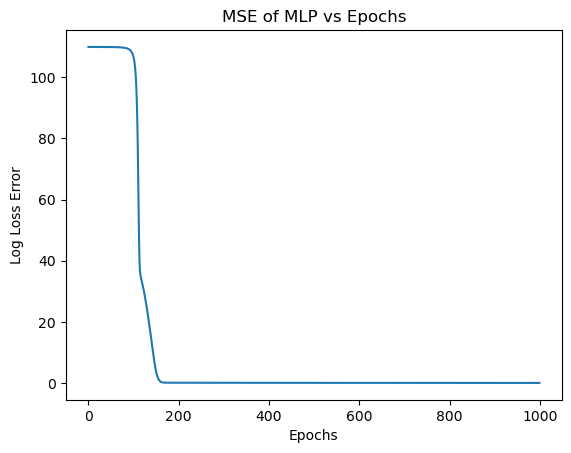

In [2918]:
# plot the change in error over iterations
plt.plot(err)
plt.title("MSE of MLP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Log Loss Error")

In [2870]:
mlp._bp_list_factors(1)[0].shape

(5, 1)

In [2821]:
mlp._bp_list_factors(1)[1].shape

(4, 10)

In [2824]:
mlp.gd(x,y,eta=0.0002,iters=1000,debug=False);

In [2844]:
x_test = np.array([10,15,-1,
                   22,-1, 3,
                    1, 1, 1,]).reshape(3,-1)
# expect y_test to be ~20, ~30, -2

mlp.fw(x_test)

array([[19.67337392, 29.49631076,  0.        ]])

In [2829]:
mlp.weights

[array([[ 8.68199078e-01,  8.68199078e-01,  8.68199078e-01,
          8.68199078e-01],
        [ 5.83538476e-04,  5.83538476e-04,  5.83538476e-04,
          5.83538476e-04],
        [-2.75651652e-02, -2.75651652e-02, -2.75651652e-02,
         -2.75651652e-02]]),
 array([[0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008]]),
 array([[0.41634832],
        [0.41634832],
        [0.41634832],
        [0.41634832],
        [0.41634832]])]

In [3400]:
mlp = MLP()
mlp.add_layer(5,LinearAF()) # input x
mlp.add_layer(10,LinearAF())   # hidden layer #1
mlp.add_layer(20,LinearAF())   # hidden layer #2
mlp.add_layer(1,ReluAF())   # prediction f_w(x)
mlp._init_weights()

e_list = mlp.gd(x.T,y.T,
                eta=0.00000001,
                iters=10000,debug=False)

In [3401]:
mlp.weights

[array([[0.017391338867137857, 0.017391338867137857, 0.017391338867137857,
         0.017391338867137857, 0.017391338867137857, 0.017391338867137857,
         0.017391338867137857, 0.017391338867137857, 0.017391338867137857,
         0.017391338867137857],
        [0.012550057332243666, 0.012550057332243666, 0.012550057332243666,
         0.012550057332243666, 0.012550057332243666, 0.012550057332243666,
         0.012550057332243666, 0.012550057332243666, 0.012550057332243666,
         0.012550057332243666],
        [0.35331307752737123, 0.35331307752737123, 0.35331307752737123,
         0.35331307752737123, 0.35331307752737123, 0.35331307752737123,
         0.35331307752737123, 0.35331307752737123, 0.35331307752737123,
         0.35331307752737123],
        [0.0009346986986028467, 0.0009346986986028467,
         0.0009346986986028467, 0.0009346986986028467,
         0.0009346986986028467, 0.0009346986986028467,
         0.0009346986986028467, 0.0009346986986028467,
         0.00093469

Text(0, 0.5, 'MSE Error')

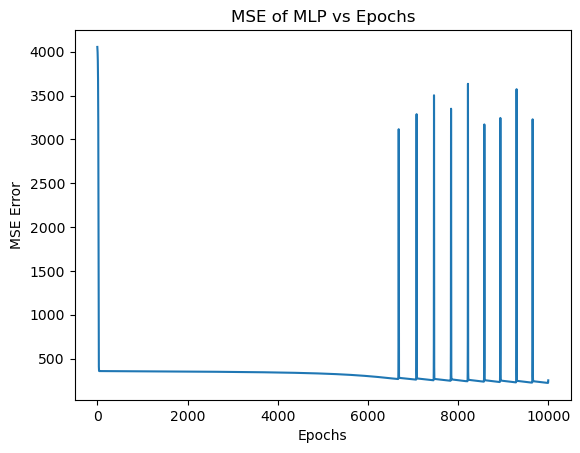

In [3402]:
# plot the change in error over iterations
plt.plot(e_list)
plt.title("MSE of MLP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Error")

In [3406]:
e_list[0:-1:500]

[4054.8251259128865,
 355.7145960379102,
 354.35352616223497,
 352.89704779708075,
 351.2853828307253,
 349.4354222179997,
 347.22281063102355,
 344.4501949983576,
 340.78986087342855,
 335.683353714475,
 328.1863528197139,
 316.8018732144638,
 299.53349705840384,
 274.8730747441704,
 261.6125903042836,
 265.80794272204236,
 252.67281363345518,
 239.958663265376,
 245.26711978093056,
 232.93872529003144]

In [3408]:
y_pred = mlp.fw(x.T)

In [3410]:
y_pred.shape

(1, 158)

In [3412]:
y.shape

(158,)

In [3414]:
y_pred = y_pred.astype(float).flatten()

In [3416]:
y.flatten()

array([73, 19, 71, 80, 80, 61, 64, 76, 68, 63, 85, 38, 62, 71, 75, 76, 62,
       75, 36, 39, 59, 64, 76, 67, 81, 54, 73, 77, 59, 92, 40, 53, 61, 77,
       67, 24, 47, 72, 53, 33, 77, 88, 51, 71, 62, 40, 63, 81, 65, 84, 24,
       73, 81, 51, 65, 57, 50, 34, 77, 57, 53, 82, 72, 75, 59, 74, 67, 49,
       72, 54, 64, 42, 41, 66, 45, 88, 68, 86, 72, 75, 70, 57, 83, 59, 83,
       49, 22, 60, 17, 18, 62, 56, 48, 66, 75, 44, 65, 55, 72, 10, 28, 68,
       96,  7, 65, 72,  0, 47, 89, 65, 21, 55, 83, 51, 40, 72, 49, 60, 56,
       75, 73, 70, 75, 79, 54, 41, 53, 63, 74, 18, 74, 58, 69, 12, 53, 75,
       39, 75, 58, 52, 56, 45, 96, 64, 68, 96, 67, 78, 79, 63, 66, 78, 53,
       72, 84, 73, 73, 77], dtype=int64)

In [3418]:
np.corrcoef(y_pred.flatten(),y.flatten())

array([[1.        , 0.67236657],
       [0.67236657, 1.        ]])

In [2832]:
test_layers = mlp.layers.copy()
test_layers

[<MLPLayer: {nodes:3,afunc:<ActivationFunction:Linear>}>,
 <MLPLayer: {nodes:4,afunc:<ActivationFunction:Linear>}>,
 <MLPLayer: {nodes:5,afunc:<ActivationFunction:Linear>}>,
 <MLPLayer: {nodes:1,afunc:<ActivationFunction:Relu>}>]

In [2834]:
test_weights = mlp.weights.copy()
test_weights

[array([[ 8.68199078e-01,  8.68199078e-01,  8.68199078e-01,
          8.68199078e-01],
        [ 5.83538476e-04,  5.83538476e-04,  5.83538476e-04,
          5.83538476e-04],
        [-2.75651652e-02, -2.75651652e-02, -2.75651652e-02,
         -2.75651652e-02]]),
 array([[0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008]]),
 array([[0.41634832],
        [0.41634832],
        [0.41634832],
        [0.41634832],
        [0.41634832]])]

In [ ]:
def test_bp(ridx):
    """ridx is the reversed index:
    - 0 refers to the last element
    - 1 refers to the 2nd to last element
    etc.
    """
    reversed_weights = list(reversed(test_weights))
    reversed_layers  = list(reversed(test_weights))
    
    prod_factors = []
    
    for i in range(ridx):
        prod_factors.append(f"reversed_layers[{i}].bp_x(...)")

    prod_factors.append(f"reversed_layers[{ridx}].bp_w(...)")
    return prod_factors

In [ ]:
test_bp(0)

In [ ]:
test_bp(1)

In [ ]:
test_bp(2)

In [ ]:
test_bp(3)

In [ ]:
list(reversed(test_weights))

In [ ]:
for i in range(5):
    print(i)

In [ ]:
for i in range(0):
    print(i)

In [ ]:
for i in range(10):
    print(10-1-i)

In [2685]:
mlp = MLP()
mlp.add_layer(2,LinearAF()) # input x
mlp.add_layer(2,ReluAF())   # hidden layer #1
mlp.add_layer(1,LinearAF())   # prediction f_w(x)
mlp._init_weights()

# run fw pass and assert shapes:
mlp.fw(x[:2,])

array([[0.0026, 0.0006, 0.    , 0.0052, 0.0016, 0.001 , 0.0018, 0.0078,
        0.008 , 0.    ]])

In [2687]:
mlp.weights

[array([[0.01, 0.01],
        [0.01, 0.01]]),
 array([[0.01],
        [0.01]])]

In [2689]:
mlp.layers

[<MLPLayer: {nodes:2,afunc:<ActivationFunction:Linear>}>,
 <MLPLayer: {nodes:2,afunc:<ActivationFunction:Relu>}>,
 <MLPLayer: {nodes:1,afunc:<ActivationFunction:Linear>}>]

In [2691]:
def bp_fw_list(idx,loss):
    """Use the "forward index"
    to procure the derivative
    of a weight."""
    weight = mlp.weights[idx]
    wshape = weight.shape
    
    # init list and append loss
    bp_list = []
    bp_list.append(loss) # 1xn
    if idx == len(mlp.weights) - 1:
        bp_list.append(mlp.layers[idx].h.T)
    if idx == len(mlp.weights) - 2:
        bp_list.append(mlp.weights[idx])
        bp_list.append(mlp.layers[idx-1].h.T)

    return bp_list

In [2769]:
bp_fw_list(1,np.ones((1,10))) # get w2

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008],
        [0.27259008, 0.27259008, 0.27259008, 0.27259008, 0.27259008]]),
 array([[10, 22,  1],
        [15, -1,  1],
        [-1,  3,  1]])]

In [2771]:
bp0 = bp_fw_list(0,np.ones((1,10))) # get w1
bp0

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])]